# Alias-Free Generative Adversarial Networks (StyleGAN3)

- [Alias-Free Generative Adversarial Networks](https://arxiv.org/abs/2106.12423)

https://nvlabs-fi-cdn.nvidia.com/_web/alias-free-gan/videos/video_0_ffhq_cinemagraphs.mp4#t=0.001

### Abstract
---

- 기존의 StyleGAN2은 texture sticking 이라는 문제를 가지고 있었습니다. 이미지는 구조적으로 학습되어야 하는데(ex. 턱에 해당하는 위치에 수염이 있어야 합니다.), StyleGAN 의 Generator는 이미지의 각 특징들을 hierarchical 방식으로 학습하지 않고 고정된 픽셀 단위로 학습을 합니다.

- interpolation 영상을 보면, StyleGAN2의 영상에서는 턱 수염이 인물을 따라가지 않고, 픽셀 단위로 고정되어 있는 것을 확인할 수 있습니다.

- 위의 문제를 해결하기 위해서 hiearchical하게 이미지를 합성할 수 있도록 alias-free 한 network 제안하였습니다.

- 그 결과, translation이나 rotation에 대해 equivariance를 만족하였으며, video나 animation을 만들기에 적합하다고 볼 수 있습니다.

### 1. Introduction
---
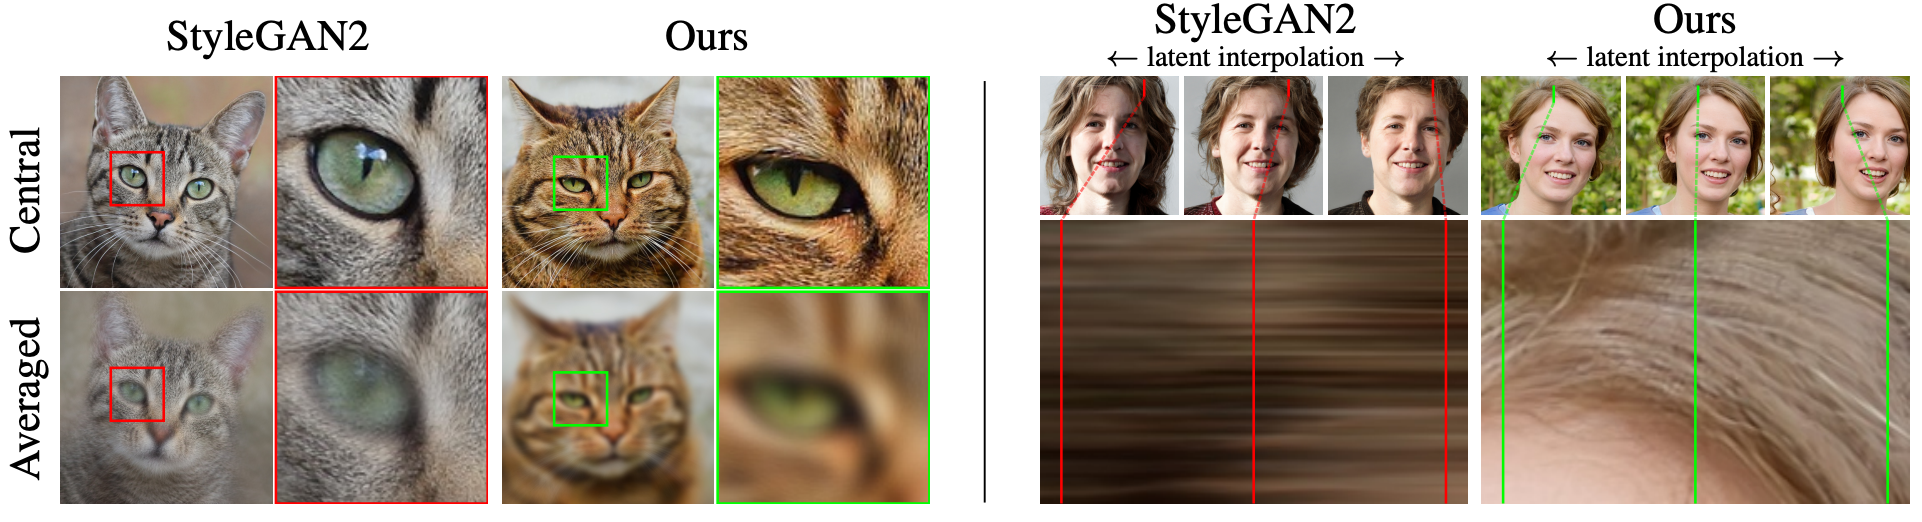

- 기존의 StyleGAN generator: coarse, low-resolution feature에서 시작하여 upsampling하고, convolution으로 local하게 mixing하고, non-linear function을 거쳐 detail들을 찾아가는 방식으로 학습해왔습니다.

    - coarse feature들이 finer feature의 여부에 대해서는 조절을 하지만, 정확한 위치까지 control하지는 못 합니다.

    - 결과적으로, fine detail이 hiearchical하게 학습되는 것이 아니라 pixel coordinate에 고착화된 상태로 학습이 됩니다.
    
- 이러한 texture sticking 문제는 위 이미지를 보면 확인할 수 있습니다.

    - 위 이미지 중 고양이 이미지를 보면, StyleGAN2은 눈을 제외한 영역이 블러처리 되지 않고, StyleGAN3에서는 모든 영역이 고르게 블러처리가 됨을 확인 할 수 있습니다. 그리고, interpolation 된 이미지를 보면, StyleGAN 2와 다르게 3에서는 translation 에 따라 자연스럽게 interpolation 됨을 확인 할 수 있습니다.

    - latent interpolation을 통해 자연스러운 transformation을 만들었을 때, 이 transformation이 hierarchy하게 조절되는 것이 아니라 각 feature들이 특정 pixel에 고착화되어 있음을 확인 할 수 있습니다.
    
> Our goal is an architecture that exhibits a more natural transformation hierarchy, where the exact sub-pixel position of each feature is exclusively inherited from the underlying coarse features.

- 1. 저자들은 위의 문제가 어디선가 의도치 않게 spatial information 이 주입 되고 있습니다.
- 2. Translation equivarient representation이 필요한데 무엇인가 이를 깨고 있음을 문제 의식으로 삼았습니다.

### 1-1. The cause of the problem
---

저자들은 현재 network가 이상적인 hierachical construction을 가지지 못하는 이유는 여러 가지가 있음을 보였습니다.

1. Image borders

2. Per-pixel noise inputs

3. Positional encoding

4. Aliasing

- 본 논문의 저자들은 이 중에서 aliasing이 가장 critical한 issue라고 주장하였습니다.

- network는 aliasing이 조금만 존재해도 이를 증폭하는 경향이 있어서 학습이 진행되면서 scale이 커질 수록 픽셀에 특정 texture가 고착되기 때문입니다.

> 그렇다면, Aliasing 는 왜 발생할까요?
>
> 1. Non-ideal upsampling filters (ex. nearest, bilinear, strided conv): Generator에서 upsampling을 하는 과정에서 low-path filtering을 하지 않기 때문입니다. 즉 ideal하지 않은 upsampling filter때문에 원치 않은 high-frequency들이 계속 더해져서 aliasing이 일어납니다.
>
> 2. Pointwise application nonlinearities such as ReLU: 예를 들어 음수일때 0으로 만들어주는 relu가 있으면 갑자기 값이 확 튀게 되기 때문에 aliasing이 일어납니다.

또한, 저자들은 이러한 aliasing에서 비롯되는 문제가 styleGAN 뿐만 아니라 deep learning에서 전반적으로 발생한다고 보고하였습니다.

그렇다면, aliasing은 어떻게 해결할 수 있을까요?

이론적으로 aliasing은 Nyquist-Shannon sampling theorem 로 해결 할 수 있습니다. 저자들은 StyleGAN2의 Generator를 신호론적으로 분석하여 upsampling filter랑 pointwise nonlinearties에서 생기는 aliasing을 해결하고자 하였습니다.

### 1-2. Equivariance란 ?
---

- 본 논문은 이미지를 생성하기 위한 다양한 operation(ex, CNN, ReLU, Upsampling / Downsampling..)에서 Equivariance 해야한다고 계속해서 주장합니다. Generator 모델을 Equivariance 하게 만드는 것이 논문의 핵심이라고 볼 수 있습니다.

먼저 Equivariance의 개념을 적립해보도록 하겠습니다.

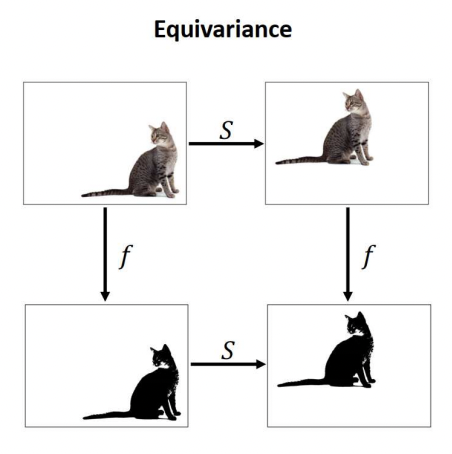

예를 들어 어떤 이미지를 회전시키고 싶을 때,

- latent code  z 로 부터 생성된 이미지를 회전시켰을 때랑

- 회전된 latent code z 에서 생성된 이미지가

같다면, 이것이 바로 rotation에 대해 equivariant 한 것이라고 합니다.

> 본 논문에서 지향하는 바는 각각의 특징들을 hierarchical하게 학습하게 만드는 것입니다.
>
> 따라서 각각의 layer들을 translation equivariant하게 만들어서 변형된 input으로 생성된 output이 일반 output을 변형한 것과 같도록 만든다면, 이미지의 각 특징들이 자연스럽게 hierarchical하게 학습될 것이라는 아이디어를 말하고자 했습니다.

### 2. Equivariance via continuous signal interpretation
---

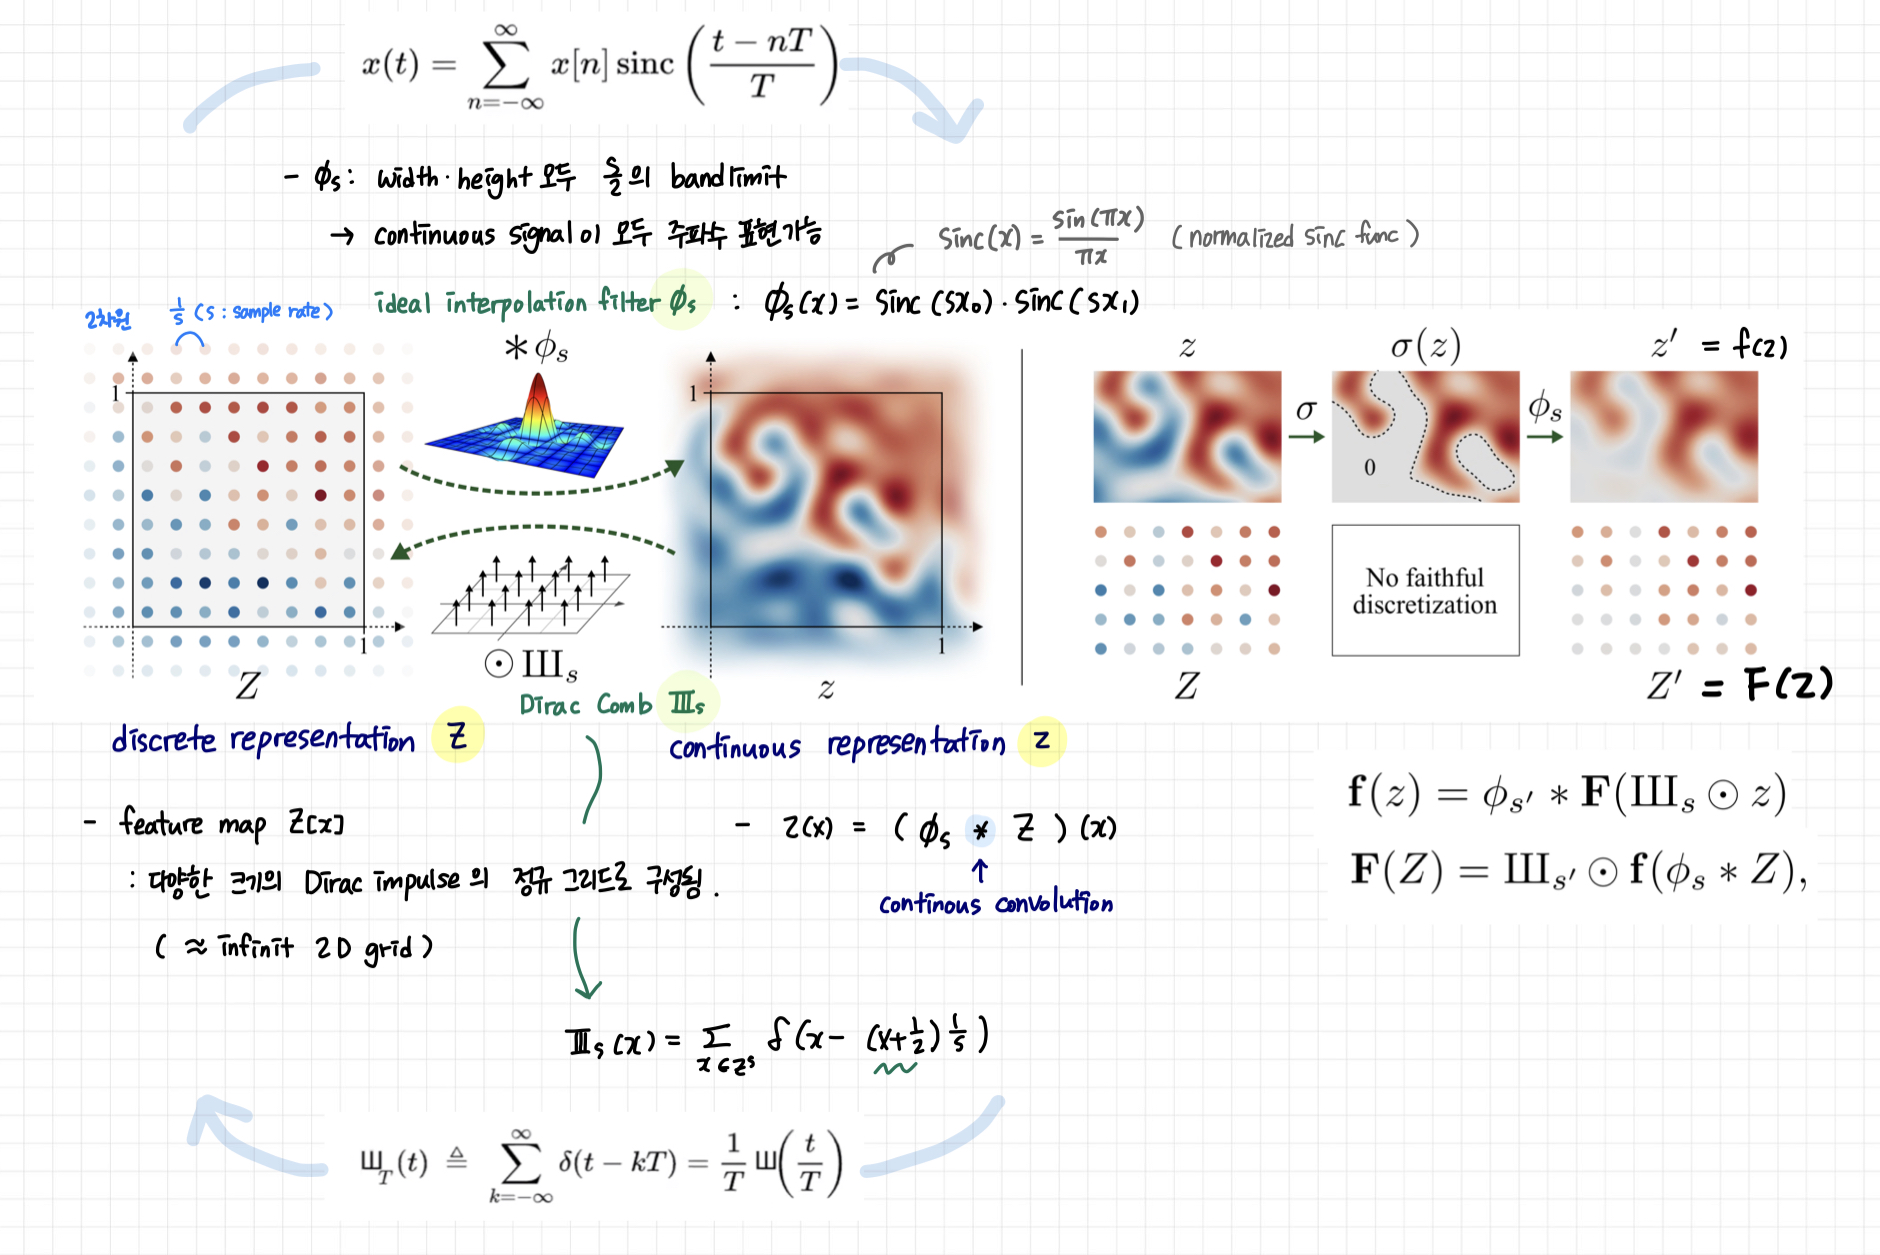

본 논문에서는 위 이미지를 보면 알 수 있듯이 discrete domin과 continous domain 사이를 자유롭게 넘나들 수 있도록 도와주는 operation에 대해서 소개하였습니다.

- sampling: continuous → discrete (by Dirac Comb)
- interpolation: discrete → continuous (by ideal interpolation filter)

- `Nyquist-Shannon Samping Theorem`

- 만약 신호가 대역제한(bandlimited)신호이고, 표본화 주파수가 신호의 대역의 두 배 이상이라면 표본으로부터 연속 시간 기저 대역 신호를 완전히 재구성할 수 있습니다.

- 입력 신호의 최고 주파수 f_max 의 2배 이상으로 모든 신호들을 균일하게 sampling 한다면, 원래 신호를 완벽하게 복원할 수 있습니다.

- aliasing 현상: 아날로그 신호를 디지털 신호에 적용할 때, sampling 속도가 2f_max 보다 작을 경우 아날로그 입력 신호에서 일부 최고 주파수 성분이 디지털 출력에 올바르게 출력되지 않습니다. 따라서 이 디지털 신호를 다시금 아날로그 신호로 변환하고자 할 때, 원래 주파수에 없던 잘못된 주파수 성분이 나타납니다.

> 이 이론에 따라 신호를 sampling 하고 나면, sampling된 discrete feature map Z(x) 이 나중에 continuous domain으로 복원하기 위한 충분한 정보를 가지고 있음을 시사합니다.

식 표현) interal T 에서 x[n]이 연속함수의 time sample 을 표현한다면, sampling rate : s = 1 / T

참고) nyquist frequency = 1 / 2 s 모든 signal을 0 ~ 1 / 2 s 사이의 주파수로 sampling하면 continous 하게 표현 가능

- Whittaker–Shannon interpolation formula (= Sinc interpolation, ideal band-limited interpolation)

-  discrete하게 sampling된 Dirac grid Z(x) 와 ideal interpolation filter ϕ_s 를 convolution하고 나면, continuous 한 신호를 복원할 수 있습니다

또한, continuous domain과 discrete domain간의 변환이 자유로우려면 각각의 domain에서 행해지는 operation간의 변환도 자유로워야합니다. (단, 이때 frequency가 bandlimit을 넘어서면 안됨)

식 표현) Recover original spectrum : X(w) = Hr(w) * X_f(w)
  = original signal = ideal recon filter * impulse sample signal
  
  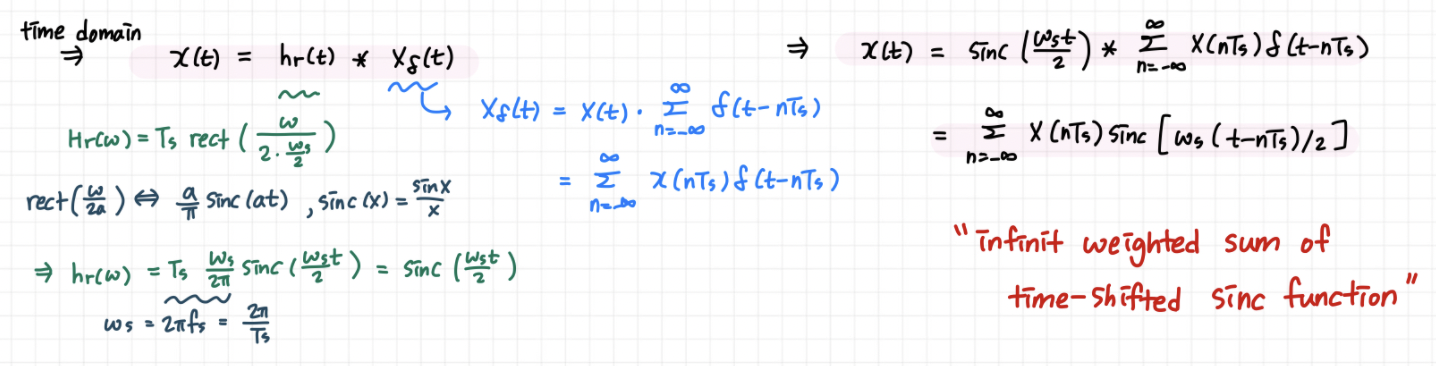

### 2.1 Equivariant network layers
---

본 논문에서는 `2가지 tranformation(translation, rotation)` 과 전형적인 generator network의 `4가지 operations(convolution, upsampling, downsampling, nonlinearity`) 에 대해서 equivariant한지 확인해주어야 합니다.

또한, `aliasing`이 없으려면 nyquist sampling을 했을 때 이상한 high frequency가 없어야한다. 즉 low-path filtering이 output까지 유지되고 있는지를 확인해줘야합니다.

### 2-1.1. Convolution

- discrete domain

우선, discrete domain에서부터 살펴보자. discrete kernel K 에서의 standard convolution은 다음과 같이 표현됩니다.

- continuous domain

discrete domain에서의 convolution 식을 continuous domain에서의 식으로 변환하면 다음과 같다.

(1) convolution은 commutativity 하므로 ϕs ∗ K = K ∗ ϕs

(2) ideal low path filter를 사용한다면, z 를 dirac comb를 통해 sampling 한 후 ideal interpolation filter로 interpolation 하면 다시 z 가 됩니다.

즉, convolution의 commutativity한 성질 (1) 때문에 translation equivariance 는 만족하며, convolution과정에서 새로운 frequency가 추가되거나 하지 않으므로 (2) domain간의 변환에서 추가적으로 aliasing 역시 생기지 않는다.

- translation 의 경우 convolution은 당연히 equivariance 합니다.

- rotation equivariance의 경우에는, discrete kernel K 가 radially symmetric해야하기 때문에 약간 주의할 필요가 있다. → 실제로 stylegan3 에서는 rotation equivariance를 만족시키기 위해 symmetric한 1x1 conv를 사용

### 2-1.2. Upsampling & Downsampling
---

#### Continuous domain에서의 Upsampling & Downsampling

continuous domain에서의 upsampling은 아무런 의미가 없습니다. (이미 infinite domain이니까)

즉, translation or rotation을 하고 upsampling 한 것과 upsampling 하고 translation or rotation 하는 것이 동일하다는 것을 의미합니다. (equivariance)

#### Discrete domain에서의 Upsampling & Downsampling

그러나 discrete한 domain에서의 upsampling filter는 ideal 하지 않기 때문에 upsampling을 하는 과정에서 aliasing이 생기고, 이 때문에 등변성이 사라집니다.

따라서 본 논문은 upsampling 과정에서 low path filtering을 하여 upsampling과 downsampling이 이상적으로 동작하는 것처럼 된다고 볼 수 있습니다. (→ equivariance)

### 2-1.3. Nonlinearity
---
Nonlinearity는 StyleGAN 의 Generator에서 유일하게 high-frequency를 학습할 수 있는 block 입니다.

그러나 non-linearity를 그냥 적용해버리면 의도치 않은 aliasing이 생길 수 있으므로 low-path filtering을 해서 새롭게 추가되는 정보의 양을 조절해야합니다.

- continuous domain에서는 ReLU가 pointwise operation이기 때문에 equivariance가 당연히 성립됩니다. 그러나 bandlimit constraint는 만족되지 않을 수도 있습니다.

- 즉, continuous domain에서 ReLU operation을 하고 나면 output에서 의도치 않은 high-frequncy가 생길 수 있다는 것이다. (aliasing)

- 논문에서는 이러한 aliasing을 제거하기 위해 non-linearity의 결과값에 low-path filtering을 해줍니다.

> 정리
> Generator가 low-resolution에서 시작하여 upsampling을 한 후, non-linearity function을 통해 detail한 부분(high-frequency)을 만들어나가는데,
>
> 이때 생성되는 high-frequency 영역들을 low-path filter를 통해 cut-off 하면서
high-frequency를 적절하게 학습하도록 합니다.

## 3. Practical application to generator network
---
2. Equivariance via continuous signal interpretation 에서는 주요 operation에서 어떤 문제가 생기는지와 그것을 어떻게 해결하는지에 대해 소개하였다면,

3. Practical application to generator network 에서는 실질적인 문제들을 해결하기 위해 어떤 식으로 network를 바꿨는지에 대해 하나씩 설명하였습니다.

### Discriminator
---
- alias-free-gan에서는 stylegan2의 discriminator 구조를 유지하였습니다.

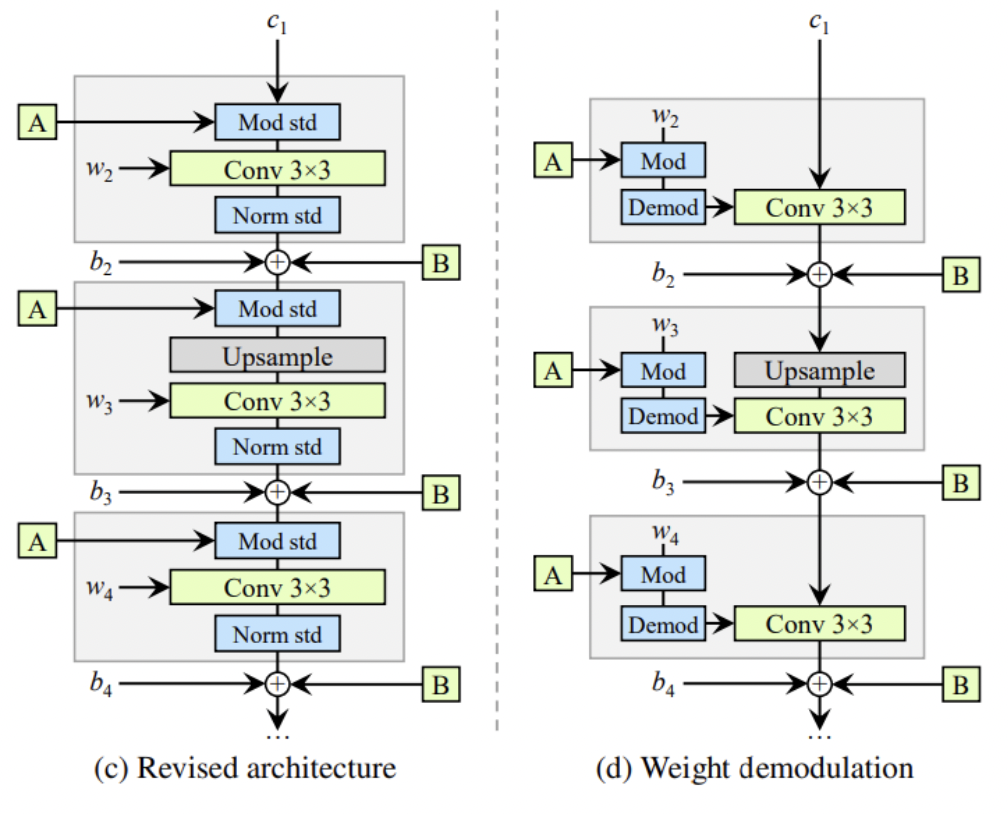

### Generator
---

1. mapping Network: initial, normally distributed latent code z 를 intermediate latent code w ∼ W 로 transform 하는 기법을 사용

2. synthesis network G: learned constant input 4x4x412 Z_0 에서 N개의 layer를 거쳐 output image Z_n = G(Z_0;w) 를 생성합니다.

- N개의 layer: consisting of convolutions, nonlinearities, upsampling, and per-pixel noise

- skip connection, mixing regularization, path length regularization 기법들도 도입하였습니다.

Generator의 operation들을 equivariance하게 만드는 것이 이 논문의 핵심이라고 볼 수 있습니다.

저자들은 각 operation이 얼마나 equivariance 한지 평가할 수 있는 방법도 함께 report 하였다.

- the peak signal-to-noise ratio (PSNR) in decibels (dB) between two sets of images
- EQ-T / EQ-R : 이 score가 높을 수록 translation / rotation에 대해 equivariance 하는 것
- 자세한 내용은 논문의 p5 를 참고하시면 됩니다.

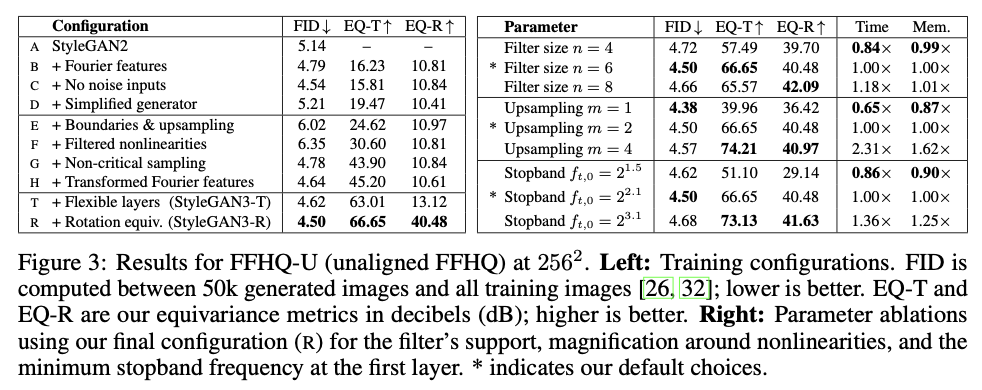

### 3.1 Fourier features and baseline simplifications (configs B–D)
---
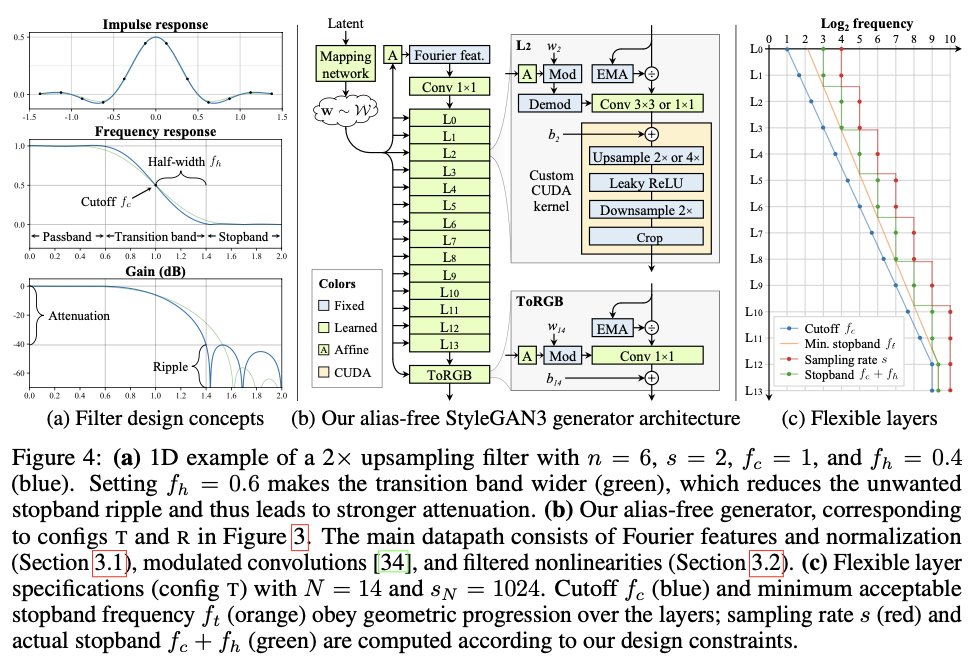

> 이미지를 continuous하게 transformation 하기 위해 learned constant input을 Fourier fearture로 변경하였습니다.

- 기존의 learned const input은 positional encoding 정보를 주기는 하지만, 좌표계가 좋지 않아 어떠한 방식으로 transformation이 작동되는지 알기 어려웠으며 이미지 공간을 explicit하게 표현했다고 하기에도 부족한 점이 많았습니다.

- StyleGAN2에서는 signal의 크기만을 encoding했다면, StyleGAN3에서는 새로운 coordinate system (SPE)을 도입하여 signal 뿐만 아니라 phase에 대한 정보도 잘 encoding하고자 하였습니다.

- StyleGAN3는 Fourier Feature (in continous한 frequency domain)으로 input을 변경하여 infinit domain으로 확장하였고, 동시에 Postional Encoding 정보도 explicit하게 줄 수 있게 되었습니다.

#### Fourier features는 stylegan3 의 코드에서 SyntehsisInput에 구현되어있습니다.

- `SyntehsisInput` block
1. intermediate latent code w 를 input으로 받아 affine 변환을 한 후,
2. 이 값을 learned transformation: (1) 먼저 image를 rotation한 후 (2) translation (3) 마지막으로는 user-specified transform
3. sampling grid를 만들어서 fourier feature로 변환

In [ ]:
# Compute Fourier features.
x = (grids.unsqueeze(3) @ freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3) # [batch, height, width, channel]
x = x + phases.unsqueeze(1).unsqueeze(2)
x = torch.sin(x * (np.pi * 2))
x = x * amplitudes.unsqueeze(1).unsqueeze(2)

### Transformed Fourier Features(config H)
---
StyleGAN3 Generator의 layer들은 equivariant하기 때문에 unaligned dataset이나 임의로 변형시킨 dataset에 대해서도 잘 학습이 된다. (만약 intermediate feature z_i를 변형시키면 final image z_N 도 변형되어 생성합니다.)

그러나 layer 자체에서 global하게 transformation 하기에는 layer의 capability가 작다. 따라서 Input Fourier Features 자체를 변형시키는 방식으로 생성되는 이미지도 transformation되도록 합니다.

- learned affine layer를 통해 input Fourier Features 가 global translation or rotation 되도록 만들어줍니다.
- SyntehsisInput code의 이 부분

In [ ]:
# Apply learned transformation.
t = self.affine(w) # t = (r_c, r_s, t_x, t_y)
t = t / t[:, :2].norm(dim=1, keepdim=True) # t' = (r'_c, r'_s, t'_x, t'_y)
m_r = torch.eye(3, device=w.device).unsqueeze(0).repeat([w.shape[0], 1, 1]) # Inverse rotation wrt. resulting image.
m_r[:, 0, 0] = t[:, 0]  # r'_c
m_r[:, 0, 1] = -t[:, 1] # r'_s
m_r[:, 1, 0] = t[:, 1]  # r'_s
m_r[:, 1, 1] = t[:, 0]  # r'_c
m_t = torch.eye(3, device=w.device).unsqueeze(0).repeat([w.shape[0], 1, 1]) # Inverse translation wrt. resulting image.
m_t[:, 0, 2] = -t[:, 2] # t'_x
m_t[:, 1, 2] = -t[:, 3] # t'_y
transforms = m_r @ m_t @ transforms # First rotate resulting image, then translate, and finally apply user-specified transform.

# Transform frequencies.
phases = phases + (freqs @ transforms[:, :2, 2:]).squeeze(2)
freqs = freqs @ transforms[:, :2, :2]

### Baseline Simplification
---
(1) per-pixel noise inputs를 제거
- StyleGAN2에 삽입되는 per-pixel noise는 이미지의 세부적인 요소들을 독립적이게 학습하도록 만들기 때문에, 이미지가 hierarchical하게 학습되지 못합니다.
- noise를 제거하면, figure5 (논문의 figure3)를 보면 FID가 그닥 개선되지는 않지만 훨씬 equivariance 할 수 있습니다.

(2) StyleGAN2-ADA에서 처럼 the mapping network depth 를 줄임

(3) disable mixing regularization and path length regularization

(4) output skip connections 제거

-> FID score를 높이기 위해 2,3,4를 했었지만, 모델을 단순화하기 위해 FID는 약간 포기하고 2,3,4를 제거하였다고 합니다.

### Step-by-step redesign motivated by continuous interpretation
---

### Boundaries and Upsampling (config E)

> Boundaries : 본 논문에서는 feature map을 무한한 공간으로 확장했다고 가정했습니다. 따라서 target canvas에 어느정도의 margin을 준 후, high-layer로 갈수록 이 확장된 canvas를 crop 하였습니다.

- border padding이 내부 이미지의 coordinate의 값을 어느정도 갖고 있기 때문에 border를 explicit하게 extension하는 과정이 필요하다.
- 실험 결과, 10-pixel margin 정도면 충분하여 이를 사용했다 한다.

> Upsampling: 기존의 bilinear 2X upsampling filter를 windowed sinc filter로 대체하여 low-pass filtering도 함께 하도록 하였습니다.

- n = 6 의 large Kaiser window : upsampling의 과정에서 output pixel은 6개의 input pixel에만 영향을 받고, downsampling의 과정에서 input pixel은 6개의 output pixel에만 영향을 준다고 합니다.

- figure5 (논문의 figure3): resampling filter를 작게 설정하면(n = 4) translation equivariance가 안좋아지고, 이를 크게 설정하면(n = 8) training 속도가 느려진다고 합니다.

#### Filtered nonlinearities (config F)
---
ReLU가 당연히 equivariance는 만족하지만, bandlimit를 지키지 않으면 aliasing이 생길 수도 있다고 보고하였다. 따라서 non-linearity function을 지날 때 low-path filtering을 꼭 해야한다.

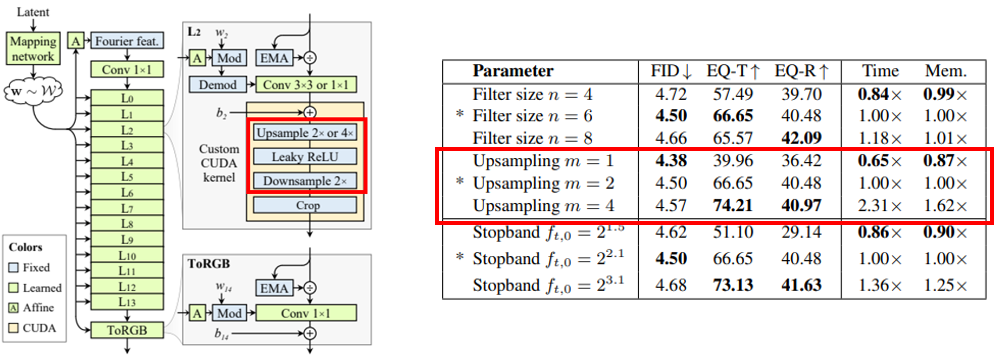

- 저자들은 upsample-leaky ReLU-downsample의 sequence가 CUDA kernel에서 효과적으로 연산되도록 최적화를 했다고 합니다. (10배 빨라짐 + memory saving)

- upsampling + downsampling 정도는 실험결과 m = 2 면 충분하다고 합니다.

### Non-critical sampling (config G) & Flexible layer (config T)
---
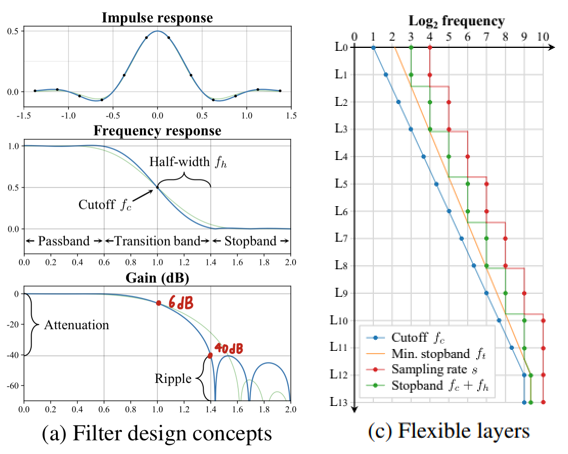

#### Non-critical sampling (config G)
---
aliasing은 generator의 equivariance를 망치는 원인이기도 하다. 따라서 각각의 layer를 지날 때 aliasing이 생기지 않도록 해야합니다.

- config G에서는 저해상도의 layer에서 aliasing이 안생기도록 cutoff frequency를 f_c = s/2 − f_h 로 낮추어 주었습니다.

#### Flexible layer (config T)
---

이렇게 aliasing을 없애는 것은 중요하다. 그러나 이미지를 학습할 때 상위 layer로 갈수록 detail을 학습하는 것도 중요하다. 즉, high-frequency도 적절히 학습을 해야하는데, low-path filtering을 너무 강하게 걸어주다보면 aliasing은 안생기겠지만 high-frequency (detail)가 학습되지 못한다.

- 따라서 config T에서는 layer를 flexible하게 조절한다.

> 정리하자면,
>
> - 저해상도의 layer에서는 aliasing이 안생기도록 lower cutoff frequency를 통해 low-path filtering을 강하게 걸어주고
> - 고해상도의 layer에서는 이미지의 detail을 학습하는게 중요하므로 flexible하게 조절하여 high-frequency를 학습하도록 합니다.

### Rotation equivariance (config R)Permalink
---
network를 rotation equivariant하게 변형하고자 할때에는 2가지를 변경한다.

1. 3x3 conv를 1x1 conv 로 변경. 대신 feature map의 수를 2배로 늘린다
2. sinc-based downsampling filter를 radially symmetric jinc-based filter로 변경합니다.
- 학습과정에서 trainable parameter가 56% 줄어드는 효과
- FID는 비슷하며 EQ-R은 약간 향상됨

### 4. Results
---
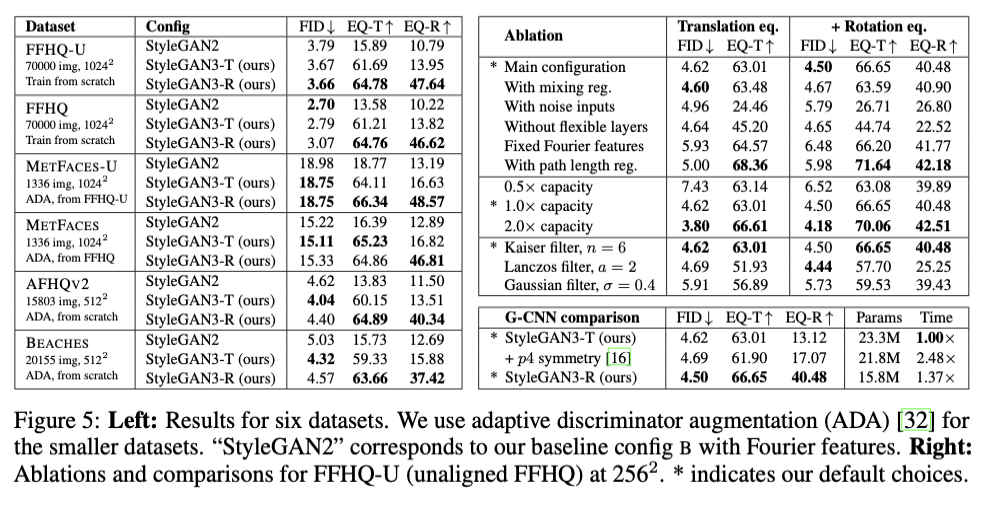

- StyleGAN3는 FID도 괜찮으며 equivarince도 좋다고 보고, training 속도 개선 + 연산 최적화 진행하였으며, unaligned image에 대해 실험했다고 합니다.

- Fourier feature라는 새로운 좌표계에서 이미지 생성을 시작하기 때문에 signal뿐만 아니라 phase 정보도 encoding할 수 있게 되었고, positional encoding 정보도 explicit하게 줄 수 있게 되었다고 합니다.